In [3]:
# !pip install gensim scikit-learn pandas

In [4]:
import random
import pandas as pd
import numpy as np
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

**Fix random seed for reproducibility**

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

**Load dataset (SMS Spam Collection)**

In [6]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_table(url, header=None, names=["label", "text"])
df["label"] = df["label"].map({"ham":0, "spam":1})

In [36]:
df.head(5)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
df = df.drop_duplicates(subset=["text"])

In [9]:
len(df)

5169

In [37]:
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [11]:
df["text"][:10].values

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       'U dun say so early hor... U c already then say...',
       "Nah I don't think he goes to usf, he lives around here though",
       "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
       'Even my brother is not like to speak with me. They treat me like aids patent.',
       "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
       'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 090617014

** Load pretrained Word2Vec (Google News 300d)**

In [12]:
%%time
kv = api.load("word2vec-google-news-300")
kv.fill_norms()

CPU times: user 19.2 s, sys: 3.77 s, total: 23 s
Wall time: 24.1 s


In [13]:
print("Word2Vec vocabulary size:", len(kv))

Word2Vec vocabulary size: 3000000


**Tokenization**

In [14]:
tokenized = [t.lower().split() for t in df["text"]]

In [15]:
tokenized[0]

['go',
 'until',
 'jurong',
 'point,',
 'crazy..',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet...',
 'cine',
 'there',
 'got',
 'amore',
 'wat...']

**Simple averaging of word vectors**

In [16]:
def sent_vector_mean(tokens):
    vecs = [kv[w] for w in tokens if w in kv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(kv.vector_size)

X_mean = np.array([sent_vector_mean(t) for t in tokenized])

**Weighted averaging using TF-IDF**

**First, build IDF dictionary on tokenized corpus**

In [17]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer.fit(tokenized)
idf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

/opt/anaconda3/envs/bio-nlp-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
def sent_vector_weighted(tokens):
    vecs, weights = [], []
    for w in tokens:
        # Check that the word exists both in the Word2Vec vocabulary and in the IDF dictionary
        if w in kv and w in idf:
            vecs.append(kv[w])      # get the Word2Vec vector for this word
            weights.append(idf[w])  # get the IDF weight for this word

    if vecs:
        # Stack all word vectors into a 2D matrix: [n_words x vector_dim]
        vecs = np.vstack(vecs)

        # Convert weights into a column vector: [n_words x 1]
        weights = np.array(weights).reshape(-1, 1)

        # Compute the weighted average:
        # multiply each word vector by its weight, sum across words,
        # then normalize by the total weight sum
        return np.sum(vecs * weights, axis=0) / np.sum(weights)
    else:
        # If no valid words are found, return a zero vector of the same dimension
        return np.zeros(kv.vector_size)

X_weighted = np.array([sent_vector_weighted(t) for t in tokenized])

**Build feature matrices**

In [19]:
X_mean = np.array([sent_vector_mean(t) for t in tokenized])
X_weighted = np.array([sent_vector_weighted(t) for t in tokenized])
y = df["label"].values

**Train/Test Split**

In [20]:
y = df["label"].values

# split indices once
idx = np.arange(len(y))

train_idx, test_idx, y_train, y_test = train_test_split(
    idx, y, test_size=0.2, random_state=SEED
)

# apply the same split to both feature sets
X_mean_train, X_mean_test = X_mean[train_idx], X_mean[test_idx]
X_w_train, X_w_test = X_weighted[train_idx], X_weighted[test_idx]

In [21]:
clf_mean = LogisticRegression(max_iter=1000)
clf_mean.fit(X_mean_train, y_train)
y_pred_mean = clf_mean.predict(X_mean_test)

print("=== Simple sent_vector_mean ===")
print(classification_report(y_test, y_pred_mean))

=== Simple sent_vector_mean ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       894
           1       0.90      0.74      0.81       140

    accuracy                           0.95      1034
   macro avg       0.93      0.86      0.89      1034
weighted avg       0.95      0.95      0.95      1034



In [22]:
clf_weighted = LogisticRegression(max_iter=1000)
clf_weighted.fit(X_w_train, y_train)
y_pred_weighted = clf_weighted.predict(X_w_test)

print("=== sent_vector_weighted (TF-IDF) ===")
print(classification_report(y_test, y_pred_weighted))

=== sent_vector_weighted (TF-IDF) ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       894
           1       0.89      0.75      0.81       140

    accuracy                           0.95      1034
   macro avg       0.93      0.87      0.89      1034
weighted avg       0.95      0.95      0.95      1034



TF-IDF weighting is more useful for **longer, noisier documents** (like news or reviews), but for **short texts + strong pretrained embeddings**, simple averaging is already a very strong baseline.


In [45]:
def predict_sms(text, model, kv, threshold=0.5):

    # tokenize
    tokens = text.lower().split()

    # use your ready function for vectorization
    sms_vec = sent_vector_mean(tokens).reshape(1, -1)

    # predict class and probability
    prob = model.predict_proba(sms_vec)[0, 1]   # probability of spam
    pred_class = int(prob >= threshold)

    print("Text:", text)
    print("Prediction:", "spam" if pred_class == 1 else "ham")
    print("Spam probability:", round(prob, 3))


In [24]:
sms = "Congratulations! You have won a free lottery ticket."
predict_sms(sms, clf_mean, kv)

Text: Congratulations! You have won a free lottery ticket.
Prediction: spam
Spam probability: 0.893


In [44]:
sms = "Congrats on winning the lottery in our office party raffle 😄"
predict_sms(sms, clf_mean, kv)

Text: Congrats on winning the lottery in our office party raffle 😄
Prediction: ham
Spam probability: 0.671


In [26]:
sms = "Reminder: Your doctor’s appointment is tomorrow at 10 AM."
predict_sms(sms, clf_mean, kv)

Text: Reminder: Your doctor’s appointment is tomorrow at 10 AM.
Prediction: ham
Spam probability: 0.118


In [27]:
sms = "Reminder: Your doctor’s appointment is tomorrow at 10 AM. Free"
predict_sms(sms, clf_mean, kv)

Text: Reminder: Your doctor’s appointment is tomorrow at 10 AM. Free
Prediction: ham
Spam probability: 0.363


In [28]:
sms = "Reminder: Your doctor’s appointment is tomorrow at 10 AM. Free Free"
predict_sms(sms, clf_mean, kv)

Text: Reminder: Your doctor’s appointment is tomorrow at 10 AM. Free Free
Prediction: spam
Spam probability: 0.629


In [42]:
sms = "Reminder: Your doctor’s appointment is tomorrow at 10 AM. Free Free Free"
predict_sms(sms, clf_mean, kv)

Text: Reminder: Your appointment is tomorrow at 10 AM. Free Free Free
Prediction: spam
Spam probability: 0.798


In [29]:
|sms = "Your card was used for $120 at StoreX. Reply YES if it was you."
predict_sms(sms, clf_mean, kv)

Text: Your card was used for $120 at StoreX. Reply YES if it was you.
Prediction: ham
Spam probability: 0.131


In [30]:
sms = "Netflix: Your subscription is expiring. Renew now and get 1 month free."
predict_sms(sms, clf_mean, kv)

Text: Netflix: Your subscription is expiring. Renew now and get 1 month free.
Prediction: spam
Spam probability: 0.834


In [31]:
sms = "Invest in our new crypto token $MOON. Guaranteed 10x profit in 7 days!"
predict_sms(sms, clf_mean, kv)

Text: Invest in our new crypto token $MOON. Guaranteed 10x profit in 7 days!
Prediction: spam
Spam probability: 0.553


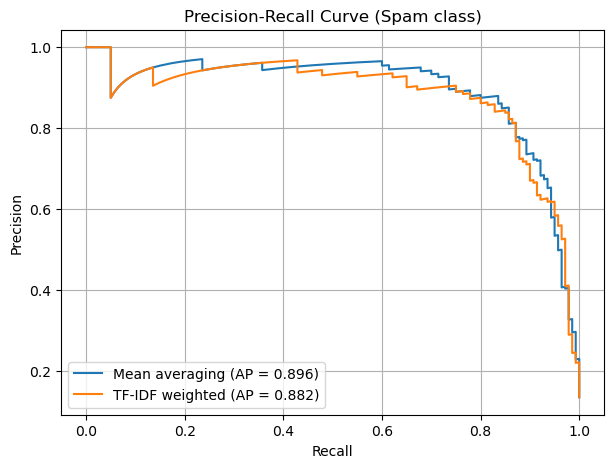

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ==== 1. Get predicted probabilities ====
# for "spam" class (label=1)
y_scores_mean = clf_mean.predict_proba(X_mean_test)[:, 1]
y_scores_weighted = clf_weighted.predict_proba(X_w_test)[:, 1]

# ==== 2. Compute curves ====
precision_mean, recall_mean, _ = precision_recall_curve(y_test, y_scores_mean)
precision_w, recall_w, _ = precision_recall_curve(y_test, y_scores_weighted)

# Average Precision (area under PR curve)
ap_mean = average_precision_score(y_test, y_scores_mean)
ap_w = average_precision_score(y_test, y_scores_weighted)

# ==== 3. Plot ====
plt.figure(figsize=(7, 5))

#AP is the area under the Precision–Recall curve.
plt.plot(recall_mean, precision_mean, label=f"Mean averaging (AP = {ap_mean:.3f})")
plt.plot(recall_w, precision_w, label=f"TF-IDF weighted (AP = {ap_w:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Spam class)")
plt.legend()
plt.grid(True)
plt.show()




*   Both models perform well (AP ~0.91 vs ~0.90)
*   Mean averaging is slightly better - higher precision at mid recall.
*   TF-IDF gives no real gain - curve mostly below mean
*   At very low recall TF-IDF = high precision, but it misses most spam

**Conclusion: simple averaging + pretrained embeddings is the stronger baseline here.**









